In [6]:
import io
import numpy as np
import polars as pl
from PIL import Image

# Get the data

In [2]:
# https://huggingface.co/datasets/wikimedia/wit_base

In [2]:
!wget https://huggingface.co/datasets/wikimedia/wit_base/resolve/main/data/train-00001-of-00330.parquet

--2025-06-05 15:07:08--  https://huggingface.co/datasets/wikimedia/wit_base/resolve/main/data/train-00001-of-00330.parquet
Resolving huggingface.co (huggingface.co)... 3.160.150.50, 3.160.150.2, 3.160.150.7, ...
Connecting to huggingface.co (huggingface.co)|3.160.150.50|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/e2/d7/e2d7a26d244e74b03e3e206b9fa071a324113e96dc2ecf918015ce67540fb780/0a5f8975ce869ef9a301e6ad11edf71ac816b8d396c95d550fc25d0b481ab3dd?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27train-00001-of-00330.parquet%3B+filename%3D%22train-00001-of-00330.parquet%22%3B&Expires=1749132428&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0OTEzMjQyOH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9lMi9kNy9lMmQ3YTI2ZDI0NGU3NGIwM2UzZTIwNmI5ZmEwNzFhMzI0MTEzZTk2ZGMyZWNmOTE4MDE1Y2U2NzU0MGZiNzgwLzBhNWY4OTc1Y2U4NjllZjlhMzAxZTZhZDExZWRmNzFhYzgxNmI4ZDM5NmM5NWQ1NTBmYzI1Z

In [4]:
!ls

sample_data  train-00000-of-00330.parquet


In [3]:
import polars as pl
ds = pl.read_parquet("train-00000-of-00330.parquet")

In [6]:
print(str(ds))

shape: (19_629, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ image     ┆ image_url ┆ embedding ┆ metadata_ ┆ … ┆ original_ ┆ mime_type ┆ caption_a ┆ wit_feat │
│ ---       ┆ ---       ┆ ---       ┆ url       ┆   ┆ width     ┆ ---       ┆ ttributio ┆ ures     │
│ struct[2] ┆ str       ┆ array[f64 ┆ ---       ┆   ┆ ---       ┆ str       ┆ n_descrip ┆ ---      │
│           ┆           ┆ , 2048]   ┆ str       ┆   ┆ i32       ┆           ┆ tio…      ┆ struct[1 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ ---       ┆ 3]       │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ str       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ {b"\xff\x ┆ https://u ┆ [1.478408 ┆ http://co ┆ … ┆ 4000      ┆ image/jpe ┆ English:  ┆ {["ro",  │
│ d8\xff\xe ┆ pload.wik ┆ 7, 2.8710 ┆ mmons.wik ┆   ┆           ┆ g     

In [4]:
# description: https://huggingface.co/datasets/wikimedia/wit_base
ds.columns

['image',
 'image_url',
 'embedding',
 'metadata_url',
 'original_height',
 'original_width',
 'mime_type',
 'caption_attribution_description',
 'wit_features']

In [8]:
# image data (first column)
ds[2,0].keys()

dict_keys(['bytes', 'path'])

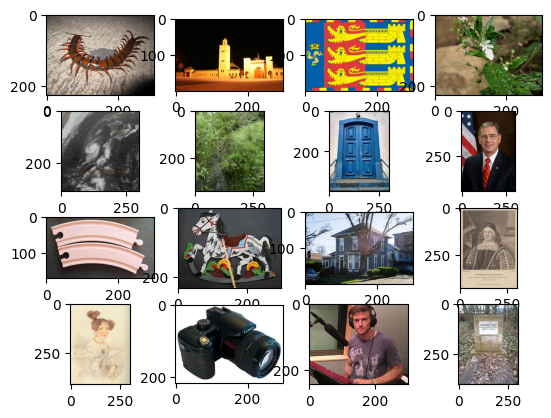

In [9]:
# show images
fig, axs = plt.subplots(4,4)
ax_rav = axs.ravel()
for j in range(len(ax_rav)):
    # get image data
    img_bytes = ds[j,0]['bytes']
    img = Image.open(io.BytesIO(img_bytes))
    img_np = np.asarray(img)
    ax_rav[j].imshow(img_np)

# Multimodal LLM from Huggingface

In [11]:
from transformers import pipeline
import torch

/home/filip/Desktop/DeepLearningProject/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
if torch.backends.cuda.is_built():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

cuda


In [13]:
pipe = pipeline(
    "image-text-to-text",
    model= "google/gemma-3-4b-it",
    device = device,
    token = "...", # authentication token from huggingface
    torch_dtype = torch.bfloat16
)

OSError: There was a specific connection error when trying to load google/gemma-3-4b-it:
401 Client Error: Unauthorized for url: https://huggingface.co/google/gemma-3-4b-it/resolve/main/config.json (Request ID: Root=1-684182f8-3e27a0e1700bab806cdf7043;b9d23147-1c7f-4702-958c-cc87aced34bd)

Invalid credentials in Authorization header

In [14]:
# prepare image 0
# images (jpg/png etc.) need to be base64 encoded to pass to LLM
import base64
img_bytes = ds[0,0]['bytes']
img_b64 = base64.b64encode(img_bytes).decode("utf-8")

In [16]:
img_b64[:100] #uses only printable characters

'/9j/4AAQSkZJRgABAQEAtAC0AAD/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYn'

In [17]:
# questions to ask
messages = [
        {
          "role": "system",
          "content": [{"type": "text", "text": "You are a helpful assistant."}]
        },
        {
          "role": "user",
          "content": [
            {"type": "image", "data": img_b64},
            {"type": "text", "text": "What is in the image?"}
          ]
        }
        ]

In [18]:
output = pipe(text=messages, max_new_tokens=200, images=[img_b64])
print(output[0]["generated_text"][-1]["content"])

The image shows a **giant centipede**. 

They are known for their elongated, segmented bodies and the rows of legs along their sides. They can be quite intimidating due to their venomous bite!


In [20]:
output[0].keys()

dict_keys(['input_text', 'generated_text'])

In [22]:
output[0]["generated_text"][-1]

{'role': 'assistant',
 'content': 'The image shows a **giant centipede**. \n\nThey are known for their elongated, segmented bodies and the rows of legs along their sides. They can be quite intimidating due to their venomous bite!'}